In [1]:
%matplotlib inline
import os
import cv2 as cv
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import itertools
from sklearn.ensemble import RandomForestClassifier
from skimage.io import imread
from skimage.feature import greycomatrix, greycoprops
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
in_dir = '5.test_sample'
binary_dir = '6.test_binary'
out_dir = '7.test_tumor_detected'
model_fname = 'model/rf_model.pkl'

In [3]:
print(os.listdir(in_dir))

['test_raw_images (1).jpeg', 'test_raw_images (1).jpg', 'test_raw_images (10).jpg', 'test_raw_images (11).jpg', 'test_raw_images (12).jpg', 'test_raw_images (13).jpg', 'test_raw_images (14).jpg', 'test_raw_images (15).jpg', 'test_raw_images (16).jpg', 'test_raw_images (17).jpg', 'test_raw_images (18).jpg', 'test_raw_images (19).jpg', 'test_raw_images (2).jpg', 'test_raw_images (20).jpg', 'test_raw_images (3).jpg', 'test_raw_images (4).jpg', 'test_raw_images (5).jpg', 'test_raw_images (6).jpg', 'test_raw_images (7).jpg', 'test_raw_images (8).jpg', 'test_raw_images (9).jpg']


In [4]:
image_name = 'test_raw_images (11).jpg'

In [5]:
Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [6]:
def detect_tumor(img_path, temp_path, output_path):
    img = cv.imread(os.path.join(in_dir,image_name))
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    orig_img = img
    gray_img = cv.cvtColor( orig_img, cv.COLOR_BGR2GRAY ) 
    median_filtered = cv.medianBlur(gray_img, 5)

    img_sobelx = cv.Sobel(median_filtered,cv.CV_8U,1,0,ksize=3)
    img_sobely = cv.Sobel(median_filtered,cv.CV_8U,0,1,ksize=3)

    img_sobel = img_sobelx + img_sobely + gray_img

    threshold = 137
    maxValue = 255

    th, thresh = cv.threshold(img_sobel, threshold, maxValue, cv.THRESH_BINARY)

    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 1)

    sure_bg = cv.dilate(opening,kernel,iterations=3)
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    _, contours, _ = cv.findContours(sure_fg.copy(),cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

    marker = np.zeros((gray_img.shape[0], gray_img.shape[1]),dtype = np.int32)

    marker = np.int32(sure_fg) + np.int32(sure_bg)

    for id in range(len(contours)):
        cv.drawContours(marker,contours,id,id+2, -1)

    marker = marker + 1

    marker[unknown==255] = 0

    copy_img = orig_img.copy()

    tumor_img = cv.watershed(copy_img, marker)

    copy_img[marker==-1]=(0,0,255)

    plt.imsave(temp_path,tumor_img,cmap='gray')

    t_img = cv.imread(temp_path)

    t_img = cv.cvtColor(t_img, cv.COLOR_BGR2RGB)

    tumor_img_gray = cv.cvtColor( t_img, cv.COLOR_BGR2GRAY )

    ret,tumor_binary_image = cv.threshold(tumor_img_gray,137,1,cv.THRESH_BINARY)
    
    plt.imsave(temp_path,tumor_binary_image,cmap='gray')
    
    plt.imshow(tumor_binary_image, cmap='gray')
    plt.axis('off')
    plt.title('Binary Image')
    plt.show()
    
    orig_img = cv.cvtColor(orig_img, cv.COLOR_RGB2GRAY)
    multi_image = orig_img * tumor_binary_image
    plt.imsave(output_path,multi_image,cmap='gray')
    
    plt.imshow(multi_image, cmap='gray')
    plt.axis('off')
    plt.title('Tumor Image')
    plt.show()

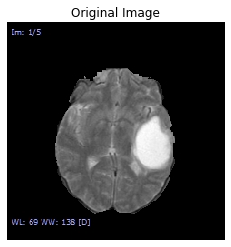

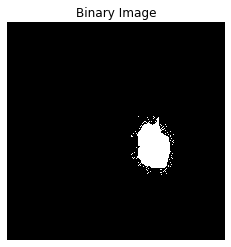

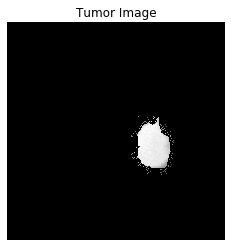

In [7]:
detect_tumor(os.path.join(in_dir,image_name), os.path.join(binary_dir,image_name), os.path.join(out_dir,image_name)) 

In [8]:
labeling_class = {
  0 : "benign",
  1 : "malignant",
  2 : "no_tumor"
}

In [9]:
loaded_forest = pkl.load(open(model_fname,'rb'))

In [10]:
def detect_tumor(img_path):
    
    img = cv.imread(img_path, 0)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    S = preprocessing.MinMaxScaler((0,11)).fit_transform(img).astype(int)

    g = greycomatrix(S, distances=[1], angles=[0], levels=256, symmetric=False, normed=False)

    contrast = greycoprops(g, 'contrast')
    energy = greycoprops(g,'energy')
    homogeneity = greycoprops(g, 'homogeneity')
    correlation = greycoprops(g, 'correlation')
    dissimilarity = greycoprops(g, 'dissimilarity')
    ASM = greycoprops(g, 'ASM')

    img1 = cv.imread(img_path,0)
    ret,thresh = cv.threshold(img1,127,255,0)
    im2,contours,hierarchy = cv.findContours(thresh, 1, 2)
    cnt = contours[0]

    area = cv.contourArea(cnt)
    perimeter = cv.arcLength(cnt,True)
    epsilon = 0.1*cv.arcLength(cnt,True)
    k = cv.isContourConvex(cnt)
    
    f_arr =  np.asarray([contrast[0][0],energy[0][0],homogeneity[0][0],correlation[0][0],dissimilarity[0][0],ASM[0][0],area,perimeter,epsilon,k])
    features = f_arr.reshape((1,10))
    class_label = loaded_forest.predict(features)[0]
    print('The predicted class label is :', labeling_class[class_label])

The predicted class label is : benign


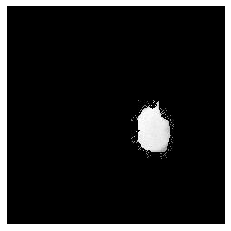

In [11]:
detect_tumor(os.path.join(out_dir,image_name))

# Done